<a href="https://colab.research.google.com/github/FKz11/NLP/blob/main/lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson-6

Тема “Классификация текста”

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили 

1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

2. Проверьте изменилось ли качество при лемматизации/и без неё

3. Замените все токены которые принадлежат сущностям на их тег. Проверьте изменилось ли качество после этого


In [ ]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 216 kB 6.7 MB/s 
     |████████████████████████████████| 133 kB 51.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [ ]:
import nltk
nltk.download('punkt')

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
pos = []
for i in train_df[train_df['is_positive']==1]['review']:
  for j in nltk.word_tokenize(i):
    pos.append(j)
pos_count = Counter(pos)

In [ ]:
neg = []
for i in train_df[train_df['is_positive']==0]['review']:
  for j in nltk.word_tokenize(i):
    neg.append(j)
neg_count = Counter(neg)

In [ ]:
pos_dict = {}
for i in pos_count.keys():
  pos_dict[i] = pos_count[i]/max(1, neg_count[i])
sorted(list(pos_dict.items()), key=lambda x: -x[1])[:10]

[('Paulie', 114.0),
 ('Edie', 109.0),
 ('Antwone', 85.0),
 ('Din', 74.0),
 ('Goldsworthy', 65.0),
 ('Gypo', 60.0),
 ('Gunga', 58.0),
 ('Blunt', 55.0),
 ('Visconti', 51.0),
 ('Iturbi', 50.0)]

In [ ]:
neg_dict = {}
for i in neg_count.keys():
  neg_dict[i] = neg_count[i]/max(1,pos_count[i])
sorted(list(neg_dict.items()), key=lambda x: -x[1])[:10]

[('Boll', 137.0),
 ('Avoid', 120.5),
 ('2/10', 119.0),
 ('Uwe', 98.0),
 ('4/10', 82.5),
 ('Seed', 68.0),
 ('Beowulf', 60.0),
 ('Thunderbirds', 54.0),
 ('Prom', 54.0),
 ('Dahmer', 50.0)]

In [ ]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'excellently', 'excellently', '10/10', '10/10', '9/10', '9/10', '8/10', '8/10', '7/10', '7/10', 'versatility', 'pickpocket', 'quibble', 'sweetly', 'sailing', 'treasured', 'scoop', 'complement', 'partition', 'knockout', 'uncompromising', 'nice', 'amazing', 'beautiful', 'fabulous' #@param {type:"raw"}
negative_words = 'worst', 'awful', 'crap', '0/10', '1/10', '1/10', '2/10', '2/10', '3/10', '3/10', '4/10', '4/10', 'unwatchable', 'atrocious', 'atrocious', 'boredom', 'boredom', 'pathetic', 'steaming', 'steaming', 'awful', 'dumber', 'drivel', 'tomatoes', 'stinker', 'terrible', 'scarecrows', 'TERRIBLE', 'interminable', 'whatsoever', 'worst', 'WORST', 'HORRIBLE', 'horrible', 'dreck', 'appallingly', 'semblance', 'pointlessly', 'leaden', 'ketchup', 'jeep', 'forwarding', 'crawling', 'dumber', 'wrists', 'mumbling', 'incoherent', 'paycheck', 'dull', 'dull', 'pointless', 'pointless', 'stupid', 'idiot' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 72.47%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [ ]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [ ]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [ ]:
vectorizer.get_feature_names()[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007']

Попробуем кого-нибудь таки сконвертировать

In [ ]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Получилось что надо.

Запустим теперь её на реальных данных.

In [ ]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [ ]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+1.855,refreshing
+1.760,wonderfully
+1.689,funniest
+1.647,surprisingly
+1.626,rare
+1.432,superb
+1.401,excellent
+1.365,incredible
+1.351,perfect
+1.302,delightful


Посмотрим на конкретные примеры его работы:

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [ ]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Посмотрим на примеры неправильной классификации, наконец:

In [ ]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
classifier_tfidf = LogisticRegression()

model_tfidf = Pipeline([
    ('vectorizer', vectorizer_tfidf),
    ('classifier', classifier_tfidf)
])

model_tfidf.fit(train_df['review'], train_df['is_positive'])

eval_model(model_tfidf, test_df)

Test accuracy = 88.28%


In [ ]:
import eli5
eli5.show_weights(classifier_tfidf, vec=vectorizer_tfidf, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+7.553,great
+6.153,excellent
+5.121,best
+4.814,perfect
+4.653,wonderful
+4.132,amazing
+4.000,well
+3.837,loved
+3.772,favorite
+3.769,fun


In [ ]:
preds_tfidf = model_tfidf.predict(test_df['review'])

#### Исправил ошибки:

count Negative, tfidf Positive, True_label Positive

count

In [ ]:
eli5.show_prediction(classifier, test_df['review'][(preds==0) & (preds_tfidf==1) & (test_df['is_positive']==1)].values[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

tfidf

In [ ]:
eli5.show_prediction(classifier_tfidf, test_df['review'][(preds==0) & (preds_tfidf==1) & (test_df['is_positive']==1)].values[0], vec=vectorizer_tfidf, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


count Positive, tfidf Negative, True_label Negative

count

In [ ]:
eli5.show_prediction(classifier, test_df['review'][(preds==1) & (preds_tfidf==0) & (test_df['is_positive']==0)].values[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


tfidf

In [ ]:
eli5.show_prediction(classifier_tfidf, test_df['review'][(preds==1) & (preds_tfidf==0) & (test_df['is_positive']==0)].values[0], vec=vectorizer_tfidf, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Начал допускать ошибки:

count Positive, tfidf Negative, True_label Positive

count

In [ ]:
eli5.show_prediction(classifier, test_df['review'][(preds==1) & (preds_tfidf==0) & (test_df['is_positive']==1)].values[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


tfidf

In [ ]:
eli5.show_prediction(classifier_tfidf, test_df['review'][(preds==1) & (preds_tfidf==0) & (test_df['is_positive']==1)].values[0], vec=vectorizer_tfidf, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


count Negative, tfidf Positive, True_label Negative

count

In [ ]:
eli5.show_prediction(classifier, test_df['review'][(preds==0) & (preds_tfidf==1) & (test_df['is_positive']==0)].values[0], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


tfidf

In [ ]:
eli5.show_prediction(classifier_tfidf, test_df['review'][(preds==0) & (preds_tfidf==1) & (test_df['is_positive']==0)].values[0], vec=vectorizer_tfidf, 
                     targets=['positive'], target_names=['negative', 'positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.76%


#### Интерпретация:

Результаты ухудшились, так как различных сочетаний из трёх слов намного больше, следовательно словарь сильно увеличился, следовательно получилось переобучение под определенные сочетания из трёх слов, которые редко встречаются

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Test accuracy = 87.86%


In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.32%


In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+7.598,great
+6.185,excellent
+5.128,best
+4.819,perfect
+4.676,wonderful
+4.165,amazing
+4.062,well
+3.835,loved
+3.806,fun
+3.783,today


Например:

In [ ]:
classifier.coef_[0][vectorizer.vocabulary_['cinema']]

0.7730359140093254

In [ ]:
classifier.coef_[0][vectorizer.vocabulary_['cinemas']]

-0.24204999728197513

Видно, что слово одно и тоже, только второе во множественном числе, а влияние они оказывают противоположное.

In [ ]:
import spacy
import en_core_web_sm
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [ ]:
for token in docs[0][:10]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls O 
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [ ]:
%%time

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

train_df['lemma'] = [' '.join([token.lemma_ for token in text]) for text in nlp.pipe(train_df['review'])]
test_df['lemma'] = [' '.join([token.lemma_ for token in text]) for text in nlp.pipe(test_df['review'])]
train_df.head()

CPU times: user 10min 36s, sys: 3.77 s, total: 10min 40s
Wall time: 10min 49s


,is_positive,review,lemma,stemm
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...


In [ ]:
vectorizer= TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemma'], train_df['is_positive'])

preds = model.predict(test_df['lemma'])
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 88.08%


In [ ]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [ ]:
%%time

train_df['stemm'] = train_df['review'].apply(lambda text: ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)]))
test_df['stemm'] = test_df['review'].apply(lambda text: ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(text)]))
train_df.head()

CPU times: user 4min 21s, sys: 679 ms, total: 4min 22s
Wall time: 4min 22s


,is_positive,review,lemma,stemm
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...


In [ ]:
vectorizer= TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stemm'], train_df['is_positive'])

preds = model.predict(test_df['stemm'])
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 88.08%


Как не странно, но с лематизацией или стеммингом метрики оказались хуже, при этом они показали одинаковые метрики, но стемминг был в 2 раза быстрее.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [ ]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

Удалим все PERSON и ORG

In [ ]:
%%time

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer'])

train_df['no_person_org'] = [' '.join([token.text for token in text if token.ent_type_!='PERSON' and token.ent_type_!='ORG']) for text in nlp.pipe(train_df['review'])]
test_df['no_person_org'] = [' '.join([token.text for token in text if token.ent_type_!='PERSON' and token.ent_type_!='ORG']) for text in nlp.pipe(test_df['review'])]
train_df.head()

CPU times: user 15min 44s, sys: 8.22 s, total: 15min 52s
Wall time: 15min 51s


,is_positive,review,lemma,stemm,no_person_org
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of Tony win i...","dreamgirl , despit it fist of toni win in an i...","Dreamgirls , despite its fistful of wins in an..."
1,0,This show comes up with interesting locations ...,this show come up with interesting location as...,thi show come up with interest locat as fast a...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...,i simpli love thi movi . i also love the ramon...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,spoiler ahead if you want to call they that .....,spoiler ahead if you want to call them that .....,Spoilers ahead if you want to call them that ....
4,1,My all-time favorite movie! I have seen many m...,my all - time favorite movie ! I have see many...,my all-tim favorit movi ! i have seen mani mov...,My all - time favorite movie ! I have seen man...


In [ ]:
vectorizer= TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['no_person_org'], train_df['is_positive'])

preds = model.predict(test_df['no_person_org'])
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

Test accuracy = 88.43%


Совсем немного, но метрика выросла!

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [ ]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 230 Patch objects>

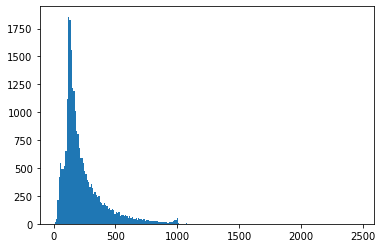

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [ ]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 27299


**Задание** Сконвертируйте данные

In [ ]:
import numpy as np

In [ ]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [ ]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1747136   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,747,907
Trainable params: 1,747,907
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 6s 12ms/step - loss: 0.5908 - accuracy: 0.7446 - val_loss: 0.3926 - val_accuracy: 0.8366
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2962 - accuracy: 0.8798 - val_loss: 0.3032 - val_accuracy: 0.8696
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1779 - accuracy: 0.9346 - val_loss: 0.2995 - val_accuracy: 0.8732
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0984 - accuracy: 0.9696 - val_loss: 0.3269 - val_accuracy: 0.8714
Epoch 5/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0467 - accuracy: 0.9901 - val_loss: 0.3663 - val_accuracy: 0.8676
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0199 - accuracy: 0.9974 - val_loss: 0.4071 - val_accuracy: 0.8659
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.4413 - val_accuracy: 0.8659

Видно, что после 3 эпохи, модель начала переобучаться

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
threshold = 0.5

preds = model.predict(X_test)
preds_int = (preds > threshold).astype(int)

print(classification_report(test_df['is_positive'], preds_int))
print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds_int)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Test accuracy = 86.54%


**Задание** Подсчитайте качество модели на тесте

### 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

In [ ]:
words_counter.most_common(30)

[('the', 322198),
 ('a', 159953),
 ('and', 158572),
 ('of', 144462),
 ('to', 133967),
 ('is', 104171),
 ('in', 90527),
 ('i', 70480),
 ('this', 69714),
 ('that', 66292),
 ('it', 65505),
 ('/><br', 50935),
 ('was', 47024),
 ('as', 45102),
 ('for', 42843),
 ('with', 42729),
 ('but', 39764),
 ('on', 31619),
 ('movie', 30887),
 ('his', 29059),
 ('are', 28743),
 ('not', 28597),
 ('film', 27777),
 ('you', 27564),
 ('have', 27344),
 ('he', 26177),
 ('be', 25691),
 ('at', 22731),
 ('one', 22480),
 ('by', 21976)]

Видно, что очень много мусорных токенов

In [ ]:
!pip -qq install stop_words

In [ ]:
from stop_words import get_stop_words

In [ ]:
get_stop_words('en')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

In [ ]:
word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
    if word in get_stop_words('en'):
        continue
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 27130


In [ ]:
X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          1736320   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,737,091
Trainable params: 1,737,091
Non-trainable params: 0
____________________________________________

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 3s 12ms/step - loss: 0.5953 - accuracy: 0.7469 - val_loss: 0.3926 - val_accuracy: 0.8347
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3016 - accuracy: 0.8760 - val_loss: 0.3059 - val_accuracy: 0.8699
Epoch 3/10
196/196 [==============================] - 2s 11ms/step - loss: 0.1817 - accuracy: 0.9345 - val_loss: 0.2961 - val_accuracy: 0.8766
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0983 - accuracy: 0.9686 - val_loss: 0.3259 - val_accuracy: 0.8744
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0429 - accuracy: 0.9900 - val_loss: 0.3689 - val_accuracy: 0.8721
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0167 - accuracy: 0.9979 - val_loss: 0.4199 - val_accuracy: 0.8690
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.4485 - val_accuracy: 0.8708

In [ ]:
threshold = 0.5

preds = model.predict(X_test)
preds_int = (preds > threshold).astype(int)

print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds_int)))

Test accuracy = 86.88%


Метрика выросла, но несущественно, а так же осталось переобучение

### 2. Проверьте изменилось ли качество при лемматизации/и без неё

In [ ]:
words_counter = Counter((word for text in train_df['lemma'] for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
    if word in get_stop_words('en'):
        continue
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 17573


In [ ]:
X_train = convert(train_df['lemma'], word2idx, 1000)
X_test = convert(test_df['lemma'], word2idx, 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 64)          1124672   
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,125,443
Trainable params: 1,125,443
Non-trainable params: 0
____________________________________________

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 3s 11ms/step - loss: 0.6117 - accuracy: 0.7464 - val_loss: 0.4154 - val_accuracy: 0.8404
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3153 - accuracy: 0.8727 - val_loss: 0.3004 - val_accuracy: 0.8717
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2171 - accuracy: 0.9172 - val_loss: 0.2860 - val_accuracy: 0.8792
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.1501 - accuracy: 0.9480 - val_loss: 0.2965 - val_accuracy: 0.8778
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0979 - accuracy: 0.9704 - val_loss: 0.3224 - val_accuracy: 0.8749
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0585 - accuracy: 0.9849 - val_loss: 0.3591 - val_accuracy: 0.8706
Epoch 7/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0318 - accuracy: 0.9942 - val_loss: 0.4014 - val_accuracy: 0.8680
Ep

In [ ]:
threshold = 0.5

preds = model.predict(X_test)
preds_int = (preds > threshold).astype(int)

print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds_int)))

Test accuracy = 86.44%


С лемматизацией метрика даже немного ухудшилась, переобучение осталось

### 3. Замените все токены которые принадлежат сущностям на их тег. Проверьте изменилось ли качество после этого

In [ ]:
from tqdm import tqdm

In [ ]:
%%time

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer'])

ner2tag_list = []
for text in tqdm(nlp.pipe(train_df['review'])):
  text_list = []
  for token in text:
    if token.ent_iob_=='B':
      text_list.append(token.ent_type_)
    if token.ent_iob_=='I':
      continue
    if token.ent_iob_=='O':
      text_list.append(token.text)
  ner2tag_list.append(' '.join(text_list))

train_df['ner2tag'] = ner2tag_list

ner2tag_list = []
for text in tqdm(nlp.pipe(test_df['review'])):
  text_list = []
  for token in text:
    if token.ent_iob_=='B':
      text_list.append(token.ent_type_)
    if token.ent_iob_=='I':
      continue
    if token.ent_iob_=='O':
      text_list.append(token.text)
  ner2tag_list.append(' '.join(text_list))

test_df['ner2tag'] = ner2tag_list

train_df.head()

25000it [08:58, 46.39it/s]
25000it [08:23, 49.61it/s]

CPU times: user 17min, sys: 12.2 s, total: 17min 12s
Wall time: 17min 23s


,is_positive,review,ner2tag
0,0,"Dreamgirls, despite its fistful of Tony wins i...","Dreamgirls , despite its fistful of PERSON win..."
1,0,This show comes up with interesting locations ...,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...,I simply love this movie . I also love the Ram...
3,0,Spoilers ahead if you want to call them that.....,Spoilers ahead if you want to call them that ....
4,1,My all-time favorite movie! I have seen many m...,My all - time favorite movie ! I have seen man...


In [ ]:
words_counter = Counter((word for text in train_df['ner2tag'] for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
    if word in get_stop_words('en'):
        continue
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 16633


In [ ]:
X_train = convert(train_df['ner2tag'], word2idx, 1000)
X_test = convert(test_df['ner2tag'], word2idx, 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

In [ ]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1064512   
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,065,283
Trainable params: 1,065,283
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 6s 13ms/step - loss: 0.6414 - accuracy: 0.6985 - val_loss: 0.4954 - val_accuracy: 0.8306
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3537 - accuracy: 0.8679 - val_loss: 0.3191 - val_accuracy: 0.8622
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2312 - accuracy: 0.9120 - val_loss: 0.3008 - val_accuracy: 0.8693
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1600 - accuracy: 0.9448 - val_loss: 0.3086 - val_accuracy: 0.8700
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1051 - accuracy: 0.9678 - val_loss: 0.3328 - val_accuracy: 0.8685
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0644 - accuracy: 0.9835 - val_loss: 0.3703 - val_accuracy: 0.8651
Epoch 7/10
196/196 [==============================] - 2s 12ms/step - loss: 0.0366 - accuracy: 0.9933 - val_loss: 0.4045 - val_accuracy: 0.8638

In [ ]:
threshold = 0.5

preds = model.predict(X_test)
preds_int = (preds > threshold).astype(int)

print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds_int)))

Test accuracy = 86.11%


Метрика опять получилась не очень, а так же осталось переобучение, видимо spacy неудалось найти все сущности и остались те, на которых мы переобучаемся, можно попробывать улучшить ситуации с помощью dropout и batchnorm. Или можно попробывать другие предобученные ner модели. Стоит отметить, что мы специально обучаем 10 эпох, чтобы увидеть переобучение и стараться его недопускать, но если у нас все равно не получается без переобучения, то тогда нужно останавливать обучение хотя бы на 3 эпохе, так как дальше идёт переобучение, так мы получим условно непереобученную модель. Так же метрику может улучшить увелечение словаря(а то сейчас у нас откидываются все токены, которые встречались меньше 10 раз) и увеличиние максимальной длины(сейчас она всего 1000, когда реальная максимальная длина больше 13000). Но главное, чтобы хватило оперативной памяти, а то иначе сеанс в колабе сбросится и все несохранённые данные(замена ner2tag длиной 18 мин) придётся получать заново, как произошло у меня :)

Но в целом суть понятна и понятно, что сущности не должны влиять и даже если с ними метрика лучше, даже если на тесте, то решение всё равно менее устойчивое к новым данным, что в продакшене недопустимо, поэтому замена сущностей это отличный подход!